In [1]:
%cd /home/yokoyama/ahar
from types import SimpleNamespace
import sys
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

sys.path.append(".")
from modules.individual import IndividualActivityRecognition, IndividualDataFormat, IndividualDataHandler
from modules.utils.video import Capture
from modules.utils.constants import Stages

/raid6/home/yokoyama/ahar


In [2]:
# set constants
model_type = "ganomaly"
train_data_dir = os.path.join("data", "dataset01", "train")
train_video_num = "10"
test_data_dir = os.path.join("data", "dataset01", "test")
test_video_num = "03"
data_types = ["bbox", "local"]
seq_len = None  # seq_len = 300

In [3]:
# load results
def load_results(data_dir, model_type, data_type, seq_len, data_keys):
    video_num = os.path.basename(data_dir)
    return IndividualDataHandler.load(data_dir, model_type, data_type, seq_len, data_keys)

data_keys = [IndividualDataFormat.kps_real, IndividualDataFormat.kps_fake]
train_results = {}
test_results = {}
for data_type in data_types:
    data_dir = os.path.join(train_data_dir, train_video_num)
    train_results[data_type] = load_results(data_dir, model_type, data_type, seq_len, data_keys)
    data_dir = os.path.join(test_data_dir, test_video_num)
    test_results[data_type] = load_results(data_dir, model_type, data_type, seq_len, data_keys)

In [4]:
def get_results_ind(results):
    ind_results = {}
    for item in results:
        pid = item[IndividualDataFormat.id]
        if pid not in ind_results:
            # initialize individual data
            ind_results[pid] = {
                key: [] for key in IndividualDataFormat.get_keys()
                if key != IndividualDataFormat.id
            }

        # append individual data
        for key, value in item.items():
            if key != IndividualDataFormat.id:
                ind_results[pid][key].append(item[key])
    return ind_results

In [5]:
train_results_ind = {}
test_results_ind = {}
for data_type in data_types:
    train_results_ind[data_type] = get_results_ind(train_results[data_type])
    test_results_ind[data_type] = get_results_ind(test_results[data_type])

In [6]:
graph = [
    # ========== 4 ============ 9 =========== 14 =====
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # Nose
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEye
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REye
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LEar
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # REar
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # LShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  # RShoulder
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # LElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # RElbow
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RWrist
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],  # LHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # RHip
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],  # LKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  # RKnee
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # LAnkle
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # RAnkle
]

def plot_keypoints(img, kps, color):
    for i in range(len(kps) - 1):
        for j in range(i + 1, len(kps)):
            if graph[i][j] == 1:
                p1 = tuple(kps[i].astype(int))
                p2 = tuple(kps[j].astype(int))
                img = cv2.line(img, p1, p2, color, 3)
    return img

In [49]:
def plot_kps(kps_results, pid, frame_num, stage, seq_len=10, n_col=10, ratio=(300, 400)):
    fig = plt.figure(figsize=(26, 7))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0)
    
    ind_result = kps_results[pid]
    frame_nums = ind_result[IndividualDataFormat.frame_num]
    idx = frame_nums.index(frame_num)
    kps_real = ind_result[IndividualDataFormat.kps_real][idx]
    kps_fake = ind_result[IndividualDataFormat.kps_fake][idx]

    step = len(kps_real) // seq_len
    kps_real = kps_real[step - 1::step]
    kps_fake = kps_fake[step - 1::step]

    mins = np.min(
        np.append(np.min(kps_real, axis=1), np.min(kps_fake, axis=1), axis=0),
        axis=0
    )
    maxs = np.max(
        np.append(np.max(kps_real, axis=1), np.max(kps_fake, axis=1), axis=0),
        axis=0
    )
    size = ((maxs - mins) * ratio).astype(int)
    kps_real = (kps_real - mins) * ratio
    kps_fake = (kps_fake - mins) * ratio
    print(mins, maxs)
    print(size)

    for j in range(seq_len):
        img = np.full((size[1], size[0], 3), 255, np.uint8)
        img = plot_keypoints(img, kps_real[j], (0, 255, 0))  # real: green
        img = plot_keypoints(img, kps_fake[j], (255, 0, 0))  # fake: red
        ax = fig.add_subplot(2, seq_len, j + 1)
        ax.imshow(img)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

    # show
    plt.savefig(
        os.path.join("data", "images", "medinfo2023", f"{stage}_{pid}_{frame_num}_kps.jpg")
    )
    plt.show()

[0.05526731 0.02754122] [0.99913174 0.97200507]
[283 377]


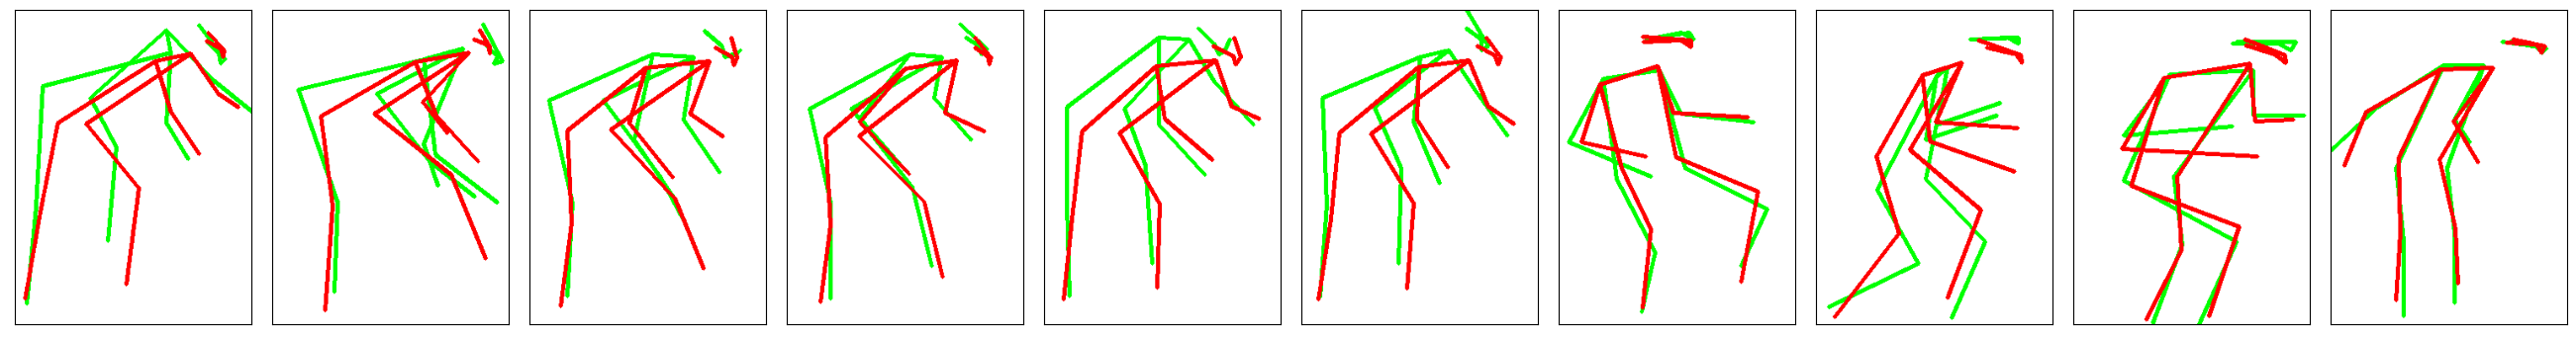

In [50]:
# train 10 272 bbox1
plot_kps(train_results_ind["local"], pid="272", frame_num=1776, stage="train")

[0.02553243 0.06054693] [1.0820322 0.9424498]
[316 352]


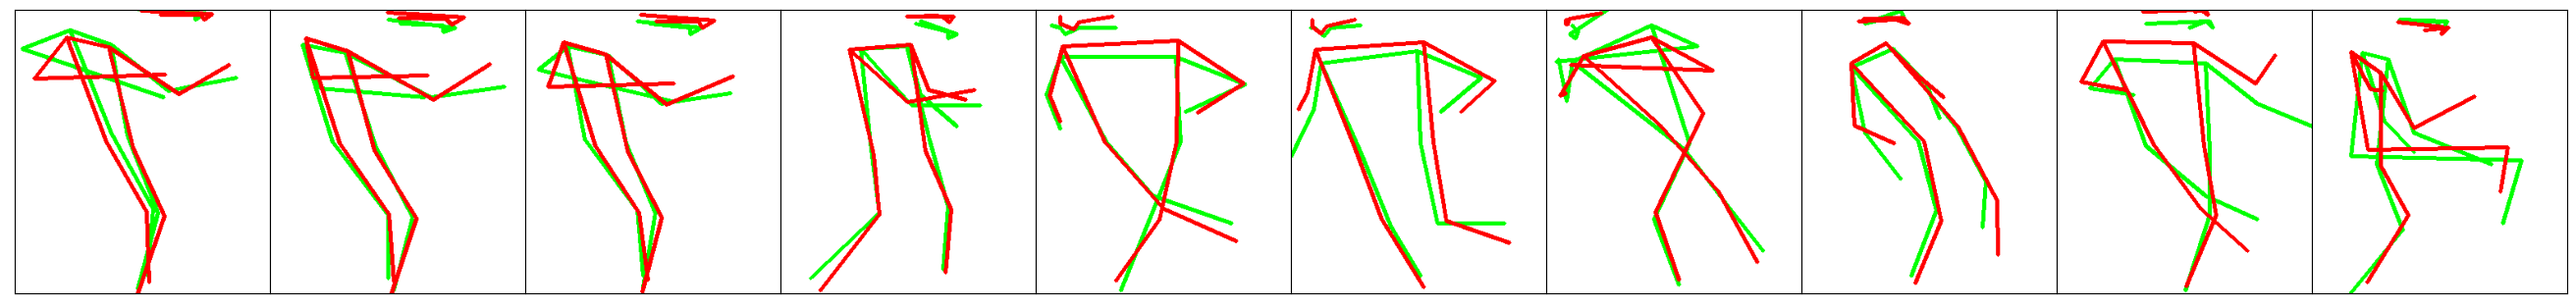

In [39]:
# train 10 272 bbox2
plot_kps(train_results_ind["local"], pid="272", frame_num=3953, stage="train")

[0. 0.] [0.98178035 0.976644  ]
[294 390]


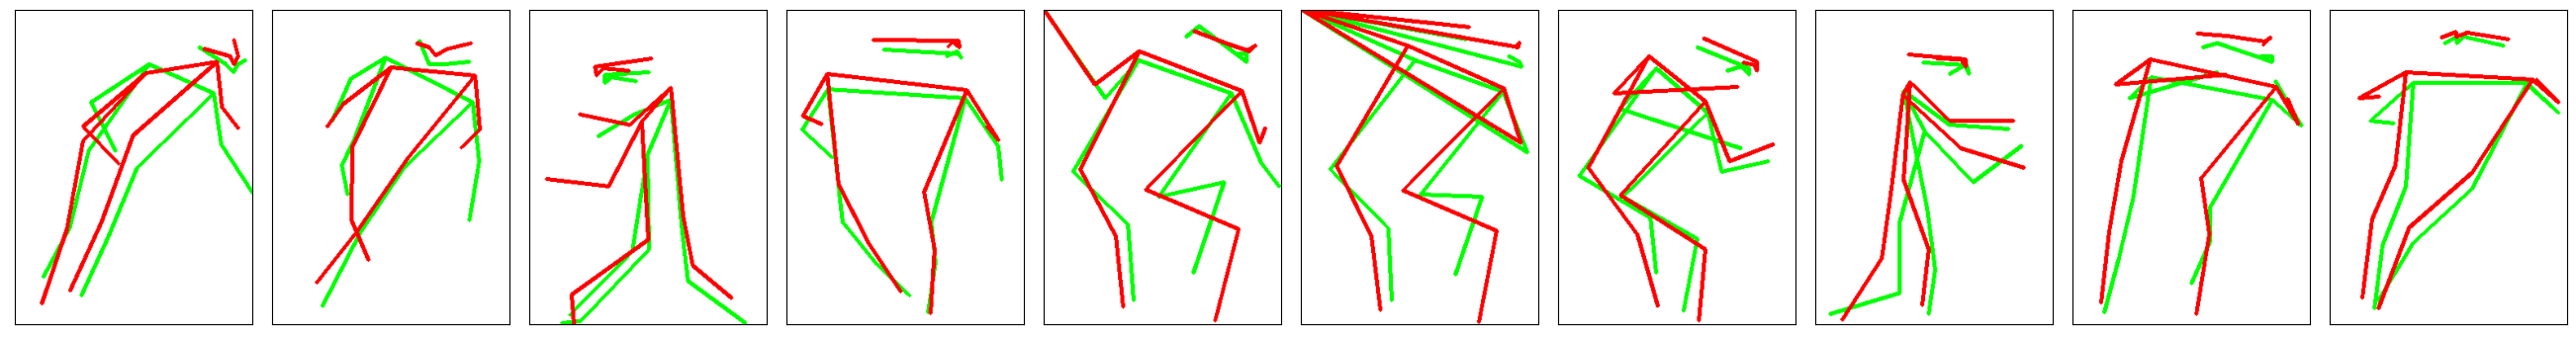

In [40]:
# test 03 56 bbox
plot_kps(test_results_ind["local"], pid="56", frame_num=1399, stage="test")

[-0.42412624 -0.12500006] [0.90408397 0.9909514 ]
[398 446]


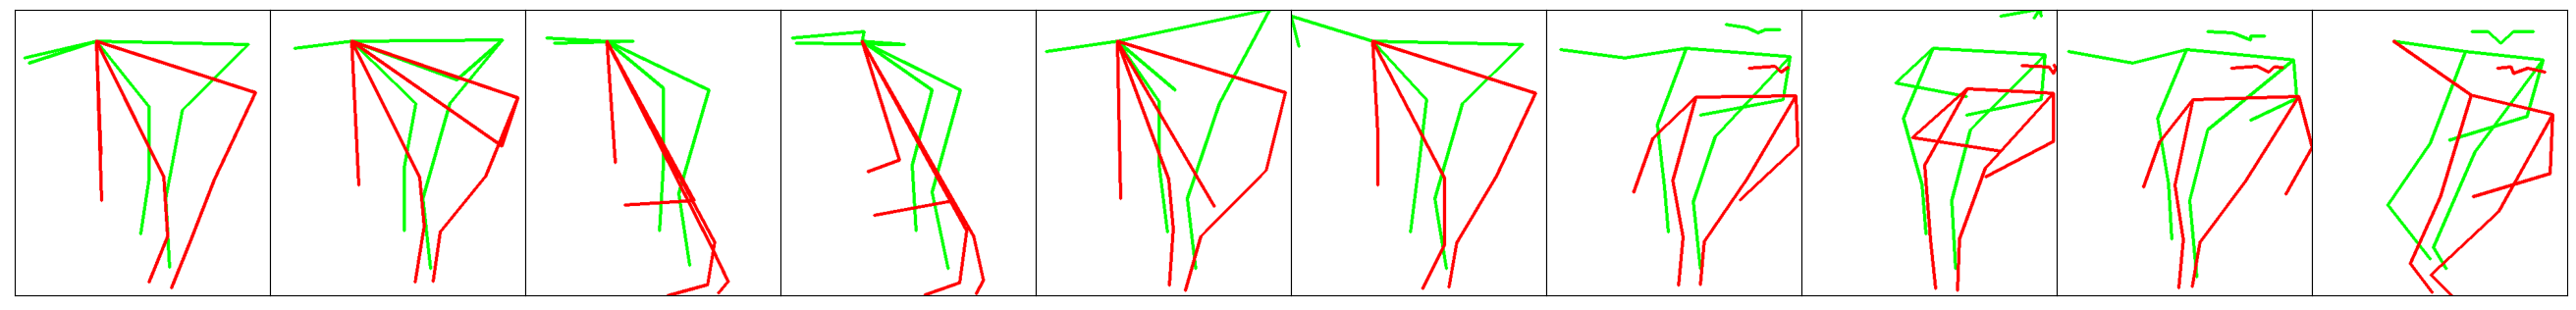

In [41]:
# test 03 56 local1
plot_kps(test_results_ind["local"], pid="56", frame_num=1037, stage="test")

[-0.04253519  0.        ] [0.9557294  0.96798223]
[299 387]


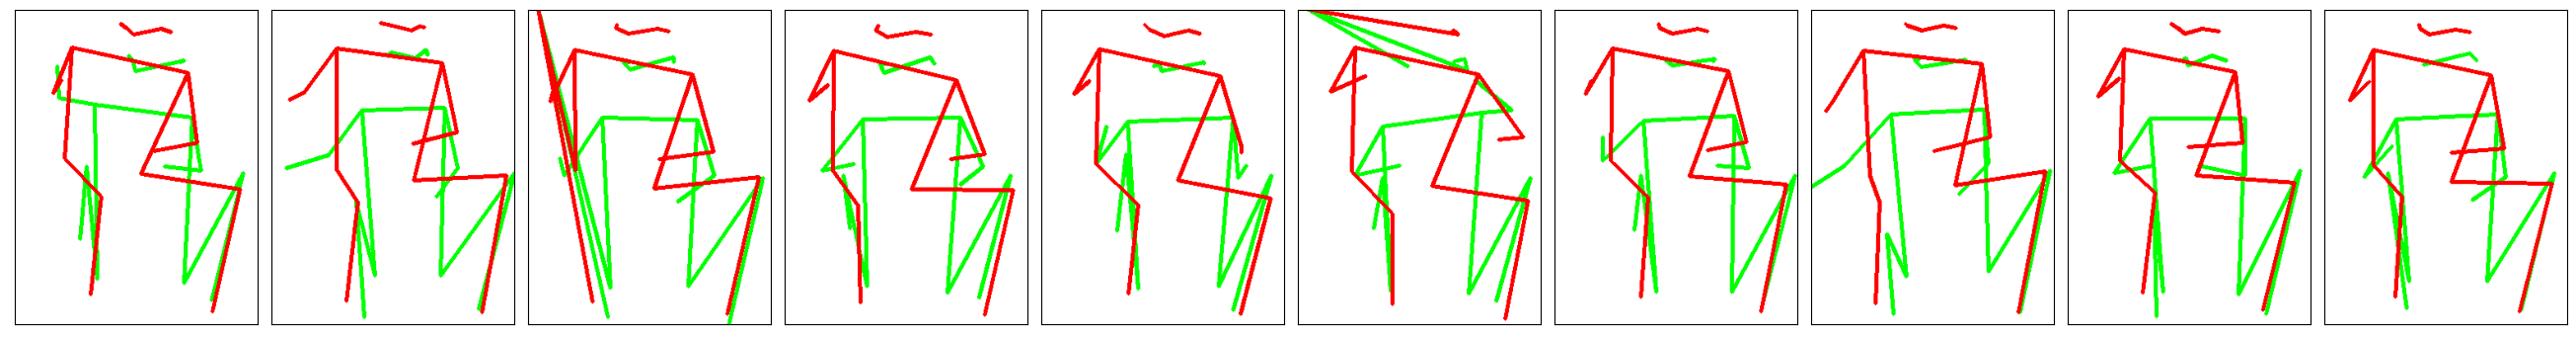

In [42]:
# test 03 56 local2
plot_kps(test_results_ind["local"], pid="56", frame_num=2010, stage="test")

# Bbox

In [51]:
def plot_bbox(img, bbox, color):
    bbox = bbox.astype(int)
    points = [
        (bbox[0][0], bbox[0][1]),
        (bbox[1][0], bbox[0][1]),
        (bbox[1][0], bbox[1][1]),
        (bbox[0][0], bbox[1][1]),
    ]
    for i in range(4):
        j = (i + 1) % 4
        p1 = points[i]
        p2 = points[j]
        img = cv2.line(img, p1, p2, color, 3)
    return img


def plot_bbox_frame(cap, bbox_results, pid, frame_num, stage, seq_len=300):
    cap.set_pos_frame_count(frame_num)
    ret, frame = cap.read()
    if not ret:
        return
    frame_shape = cap.size
    
    ind_result = bbox_results[pid]
    frame_nums = ind_result[IndividualDataFormat.frame_num]
    idx = frame_nums.index(frame_num)
    kps_real = ind_result[IndividualDataFormat.kps_real][idx]
    kps_real = np.array(kps_real) * frame_shape
    kps_fake = ind_result[IndividualDataFormat.kps_fake][idx]
    kps_fake = np.array(kps_fake) * frame_shape
    
    plot_bbox(frame, kps_real[-1], (0, 255, 0))
    for i in range(seq_len - 1):
        j = i + 1
        
        p1 = tuple(kps_real[i][0].astype(int))
        p2 = tuple(kps_real[j][0].astype(int))
        frame = cv2.line(frame, p1, p2, (0, 255, 0), 5)
        
        p1 = tuple(kps_fake[i][0].astype(int))
        p2 = tuple(kps_fake[j][0].astype(int))
        frame = cv2.line(frame, p1, p2, (255, 0, 0), 5)
        
    plt.imshow(frame)
    plt.axis("off")
    plt.show()
    cv2.imwrite(
        os.path.join("data", "images", "medinfo2023", f"{stage}_{pid}_{frame_num}_bbox.jpg"),
        cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    )

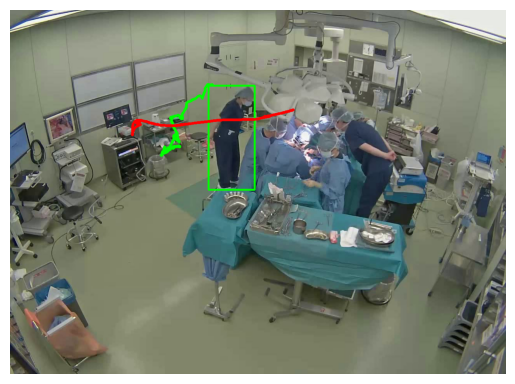

In [52]:
train_cap = Capture(os.path.join("/raid6/home/yokoyama/datasets/dataset01/train", "10.mp4"))
plot_bbox_frame(train_cap, train_results_ind["bbox"], "272", 1776, "train")
del train_cap

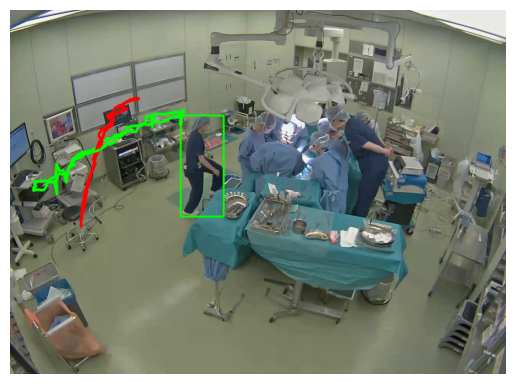

In [53]:
train_cap = Capture(os.path.join("/raid6/home/yokoyama/datasets/dataset01/train", "10.mp4"))
plot_bbox_frame(train_cap, train_results_ind["bbox"], "272", 3953, "train")
del train_cap

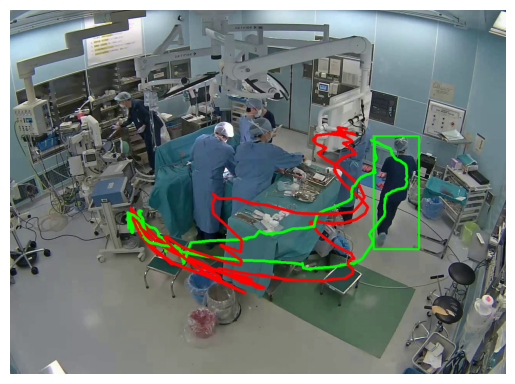

In [54]:
test_cap = Capture(os.path.join("/raid6/home/yokoyama/datasets/dataset01/test", "03.mp4"))
plot_bbox_frame(test_cap, test_results_ind["bbox"], "56", 1399, "test")
del test_cap

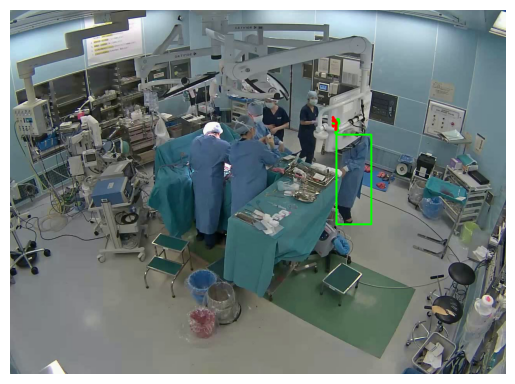

In [55]:
test_cap = Capture(os.path.join("/raid6/home/yokoyama/datasets/dataset01/test", "03.mp4"))
plot_bbox_frame(test_cap, test_results_ind["bbox"], "56", 1037, "test")
del test_cap

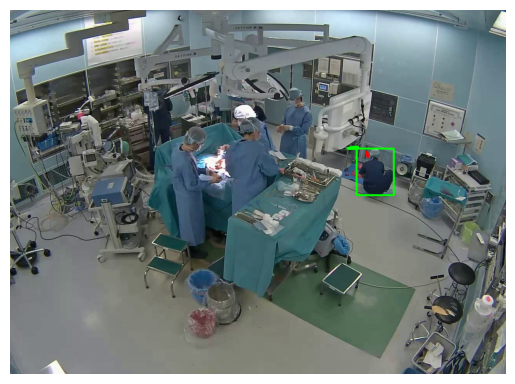

In [56]:
test_cap = Capture(os.path.join("/raid6/home/yokoyama/datasets/dataset01/test", "03.mp4"))
plot_bbox_frame(test_cap, test_results_ind["bbox"], "56", 2010, "test")
del test_cap